In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from timeit import default_timer as timer

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [3]:
## getting the dataset
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
# check the dataset
len(train_dataset), len(test_dataset)

(60000, 10000)

In [5]:
class_names = train_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
class_to_idx = train_dataset.class_to_idx
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [7]:
image, label = train_dataset[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

(-0.5, 27.5, 27.5, -0.5)

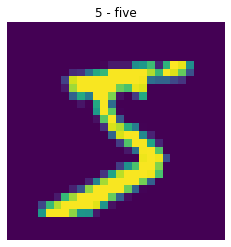

In [8]:
# visualize the dataset
plt.imshow(image.squeeze()) # remove the singular dim
plt.title(class_names[label])
plt.axis(False)

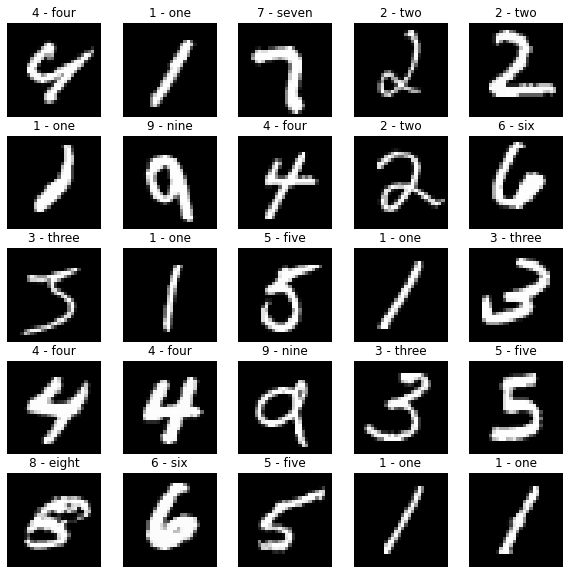

In [9]:
# visualize more dataset
fig = plt.figure(figsize=(10, 10))
rows, cols = 5, 5
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
  img, label = train_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [10]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
## perpare DataLoader

# setup batch size
BATCH_SIZE = 32

# turn datasets into iterable batches
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [12]:
print(f"Number of train batches (each one contains {BATCH_SIZE}) is {len(train_dataloader)}")
print(f"Number of test batches (each one contains {BATCH_SIZE}) is {len(test_dataloader)}")

Number of train batches (each one contains 32) is 1875
Number of test batches (each one contains 32) is 313


In [13]:
batches, labels = next(iter(train_dataloader))
print(labels.shape)
print(batches.shape)

torch.Size([32])
torch.Size([32, 1, 28, 28])


In [14]:
## setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
device

'cuda'

In [16]:
## build a baseline model
class MNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [17]:
# instantiate a model
model_0 = MNISTModelV0(input_shape=28*28,
                       hidden_units=10,
                       output_shape=10).to(device)

model_0

MNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
## loss, optimizer and evaluation metrics
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                        lr=0.1)

In [19]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 17.5 MB/s eta 0:00:00


In [20]:
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=10).to(device)

In [21]:
## create a function to time our experiment
def print_train_time(start: float,
                     end: float,
                     device: torch.device=device):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [22]:
## create train/test loop functions
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device=device):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    # 1. forward pass
    y_pred = model(X)
    # 2. calcualte the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
    # 3. optimizer zero grad
    optimizer.zero_grad()
    # 4. loss backward
    loss.backward()
    # 5. optimizer step
    optimizer.step()
  
  train_loss /= len(data_loader)
  train_acc = (train_acc / len(data_loader)) * 100

  # print ot what is happening
  print(f"Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}%\n")

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn,
              accuracy_fn,
              device=device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      # 1. forward pass
      test_pred = model(X_test)
      # 2. calculate the loss
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc = (test_acc / len(data_loader)) * 100

    # print out what is happening
    print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}%")

In [23]:
## create make predictions model to get model's result
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn,
               accuracy_fn,
               device=device):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim=1))
    
    loss /= len(data_loader)
    acc = (acc / len(data_loader)) * 100

  return {
      "model name": model.__class__.__name__,
      "model loss": loss.item(),
      "model accuracy": acc.item()
  }

In [24]:
## fit the data to the model and make prediction

train_time_start = timer()

epochs = 3

# create an optimization/evaluation loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------------------")
  train_step(
      model=model_0,
      data_loader=train_dataloader,
      loss_fn=loss_fn,
      accuracy_fn=accuracy_fn,
      optimizer=optimizer
  )

  test_step(
      model=model_0,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      accuracy_fn=accuracy_fn
  )

train_time_end = timer()

total_train_time_model_0 = print_train_time(
    start=train_time_start,
    end=train_time_end
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------------------
Train Loss: 0.402, Train Accuracy: 88.600%

Test Loss: 0.297, Test Accuracy: 91.583%
Epoch: 1
------------------
Train Loss: 0.308, Train Accuracy: 91.270%

Test Loss: 0.303, Test Accuracy: 91.354%
Epoch: 2
------------------
Train Loss: 0.295, Train Accuracy: 91.673%

Test Loss: 0.286, Test Accuracy: 91.813%
Train time on cuda: 37.715 seconds


In [25]:
model_0_results = eval_model(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_0_results

{'model name': 'MNISTModelV0',
 'model loss': 0.2854873538017273,
 'model accuracy': 91.83306884765625}

In [26]:
from torch.nn.modules.flatten import Flatten
from numpy import pad
## create a CNN model
class MNISTModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # print to know th exact number
                  out_features=output_shape)
    )
  
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x


In [27]:
from re import M
# instantiate a model
model_1 = MNISTModelV1(
    input_shape=1,
    hidden_units=10,
    output_shape=10
).to(device)

model_1

MNISTModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [28]:
# setup the loss, optimizer, and evaluation metric (Accuracy)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [29]:
train_time_start = timer()

# Train and test mode
epochs = 10

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------------")

  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
  
train_time_end = timer()
total_train_time_model_2 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------------
Train Loss: 0.295, Train Accuracy: 90.215%

Test Loss: 0.073, Test Accuracy: 97.654%
Epoch: 1
---------------
Train Loss: 0.080, Train Accuracy: 97.563%

Test Loss: 0.059, Test Accuracy: 97.963%
Epoch: 2
---------------
Train Loss: 0.064, Train Accuracy: 98.018%

Test Loss: 0.052, Test Accuracy: 98.333%
Epoch: 3
---------------
Train Loss: 0.053, Train Accuracy: 98.288%

Test Loss: 0.067, Test Accuracy: 97.754%
Epoch: 4
---------------
Train Loss: 0.049, Train Accuracy: 98.490%

Test Loss: 0.046, Test Accuracy: 98.482%
Epoch: 5
---------------
Train Loss: 0.045, Train Accuracy: 98.555%

Test Loss: 0.043, Test Accuracy: 98.542%
Epoch: 6
---------------
Train Loss: 0.042, Train Accuracy: 98.705%

Test Loss: 0.042, Test Accuracy: 98.692%
Epoch: 7
---------------
Train Loss: 0.040, Train Accuracy: 98.755%

Test Loss: 0.037, Test Accuracy: 98.812%
Epoch: 8
---------------
Train Loss: 0.035, Train Accuracy: 98.852%

Test Loss: 0.044, Test Accuracy: 98.602%
Epoch: 9
-

In [30]:
model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_1_results

{'model name': 'MNISTModelV1',
 'model loss': 0.04824530705809593,
 'model accuracy': 98.51238250732422}

In [31]:
## evaluate the model by creating make predictions model
def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [32]:
import random

# generate 9 sample from test datasets
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# print the first test sample shape
print(f"Test sample image shape: {test_samples[0].shape}, \n Test sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28]), 
 Test sample label: 2 (2 - two)


In [33]:
len(test_samples)

9

In [34]:
# make prediction on model 1
pred_probs = make_predictions(model=model_1,
                              data=test_samples)

pred_probs[1]

tensor([2.0854e-18, 5.6481e-12, 9.7203e-15, 1.0000e+00, 4.3812e-22, 7.2575e-10,
        2.1695e-18, 1.6366e-12, 8.8548e-14, 6.4126e-17])

In [35]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 3, 1, 6, 9, 7, 5, 8, 0])

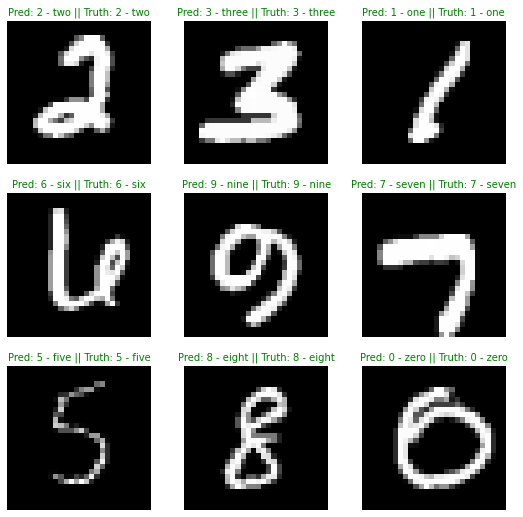

In [36]:
# plot the predictions

plt.figure(figsize=(9, 9))

nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  # create subplot
  plt.subplot(nrows, ncols, i+1)

  # plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} || Truth: {truth_label}"

  # check the equality and change the color accordingly
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)